In [1]:
import numpy as np
import lz4
import nibabel
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import pyro_method, DenseNN
from pyro.distributions.conditional import ConditionalTransformModule
import sys
sys.path.insert(0,"../data/")
import torch
from loader import *

In [2]:
def init_weights(m):
    if (type(m) == nn.Conv3d or
        type(m) == nn.ConvTranspose2d or
        type(m) == nn.Conv2d
       or type(m)== nn.Linear):
        nn.init.kaiming_normal_(m.weight,mode='fan_in',a=.01,nonlinearity="leaky_relu")
        nn.init.zeros_(m.bias)

In [3]:
def crop(x,x1,x2,y1,y2,z1,z2):
    return x[x1:x2,y1:y2,z1:z2]
def downsample(x,factorx,factory=None,factorz=None):
    if factory==None:
        factory=factorx
    if factorz==None:
        factorz=factorx
    return x[::factorx,::factory,::factorz]
def brain_slice(x,slice_num):
    return x[:,:,slice_num]
def normalize(x,norm_type=None):
    x-=np.min(x,keepdims=True)
    x/=(np.max(x,keepdims=True)+.00001)
    return x
    
def load_one_brain(path):
    img=nibabel.load(path)
    img=img.get_fdata()
    
    print(img.shape)
    img=crop(img,50,178,50,178,12,140)
    print(img.shape)
    return img


In [4]:
def view_slice(volume,slice_num):
    plt.imshow(volume[:,:,slice_num],cmap="Greys")

In [5]:
basic_brain=load_one_brain("/usr/local/faststorage/BraTS19_Data/Training/Data/BraTS19_2013_3_1/BraTS19_2013_3_1_flair.nii.gz")


(240, 240, 155)
(128, 128, 128)


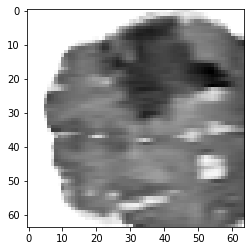

In [6]:
view_slice(downsample(basic_brain,2),32)

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim=64,k=4):
        super().__init__()
        self.conv1=nn.Conv2d(1, k, kernel_size=3, stride=1)
        self.conv2=nn.Conv2d(k, 2*k, kernel_size=3, stride=2,padding=1)
        self.conv3=nn.Conv2d(2*k, 4*k, kernel_size=3, stride=2,padding=1)
        self.conv4=nn.Conv2d(4*k, 6*k, kernel_size=3, stride=2,padding=1)
        #self.fc1=nn.Linear(6*k*8*8,64)
        self.z_mean_fc=nn.Linear(16*6*k,z_dim)
        self.z_std_fc=nn.Linear(16*6*k,z_dim)
        self.ap=nn.AdaptiveAvgPool2d((4,4))
        self.lrelu=nn.LeakyReLU()
    def forward(self, xs):
        x=self.lrelu(self.conv1(xs))
        x=self.lrelu(self.conv2(x))
        x=self.lrelu(self.conv3(x))
        x=self.lrelu(self.conv4(x))
        x=self.ap(x)
        x=x.view(x.shape[0],-1)
        z_loc=self.z_mean_fc(x)
        z_scale=torch.exp(self.z_std_fc(x))
        return z_loc,z_scale

In [8]:
class Decoder(nn.Module):
    def __init__(self, z_dim=64,k=4):
        super().__init__()
        
        self.deconv1=torch.nn.ConvTranspose2d(z_dim, 6*k, kernel_size=4, stride=2,padding=1)
        self.deconv2=torch.nn.ConvTranspose2d(6*k, 4*k, kernel_size=4, stride=2,padding=1)
        self.deconv3=torch.nn.ConvTranspose2d(4*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.deconv4=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.deconv5=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.deconv6=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.conv1=torch.nn.Conv2d(2*k,2,kernel_size=3,stride=1,padding="same")

        self.relu = nn.ReLU()
        
        self.lrelu=nn.LeakyReLU()

        self.Sigmoid = nn.Sigmoid()
    def forward(self, z):
        z=z.unsqueeze(2).unsqueeze(3)
        #print(z)
        x = self.lrelu(self.deconv1(z))
        x = self.lrelu(self.deconv2(x))
        
        x = self.lrelu(self.deconv3(x))
        x = self.lrelu(self.deconv4(x))
        x = self.lrelu(self.deconv5(x))
        x = self.lrelu(self.deconv6(x))
        #print(x)
        x=self.conv1(x)
        #print(x.shape)
        recon_loc=x[:,0,...]
        recon_var=torch.exp(x[:,1,...])
        
        
        return recon_loc,recon_var
        


In [9]:
class ConditionalAffineTransform(ConditionalTransformModule):
    def __init__(self, context_nn, event_dim=0, **kwargs):
        super().__init__(**kwargs)
        self.event_dim = event_dim
        self.context_nn = context_nn

    def condition(self, context):
        loc, log_scale = self.context_nn(context)
        scale = torch.exp(log_scale)
        ac = transforms.AffineTransform(loc, scale, event_dim=self.event_dim)
        return ac

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size=1,z_dim=64,k=4):
        super().__init__()
        fc_1=nn.Linear(input_size,4)
        fc_z_mean=nn.Linear(4,1)
        fc_z_std=nn.Linear(4,1)
        self.Sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()
    def forward(self,z,y):
        x=self.relu(fc_1(y))
        affine_1=fc_z_mean(x)
        affine_2=fc_z_std(x)
        return affine_1,affine_2
class Estimator(nn.Module):
    def __init__(self, input_size=64,z_dim=1,k=4):
        super().__init__()
        self.fc_1=nn.Linear(input_size,16)
        self.fc_z_mean=nn.Linear(16,1)
        self.fc_z_std=nn.Linear(16,1)
        self.Sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()
    def forward(self,z):
        x=self.relu(self.fc_1(z))
        affine_1=self.fc_z_mean(x)
        affine_2=torch.exp(self.fc_z_std(x))
        return affine_1,affine_2

In [22]:
class CVAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.encoder = Encoder(z_dim,k=2)
        self.encoder.apply(init_weights)
        self.decoder = Decoder(z_dim+1,k=2)
        self.decoder.apply(init_weights)

        #self.prior_net.train()
        #self.generation_net.train()
        self.z_dim=z_dim
        #self.recognition_net = Encoder(z_dim,k=4)
        self.age_nn=MLP(input_size=1,z_dim=4)
        #self.age_flow_components = ConditionalAffineTransform(context_nn=age_nn, event_dim=0)
        #self.age_flow_transforms = [self.age_flow_components]
        self.age_estimator=Estimator(input_size=64,z_dim=1)
    #@pyro_method
    #def pgm_model(self):

        #return {'age': age_base_dist}
        
    def model(self, xs,age=None):
            # register this pytorch module and all of its sub-modules with pyro
            
            pyro.module("decoder",self.decoder)
            with pyro.plate("data",xs.shape[0]):
                
                #obs=pgm_model()
                age_mean=xs.new_ones(torch.Size((xs.shape[0], 1)))*60.8
                age_base_scale=xs.new_ones(torch.Size((xs.shape[0], 1)))*12.89
                age_dist = dist.Normal(age_mean, age_base_scale).to_event(1)
                age = pyro.sample('age', age_dist)
                
                
                #slice_min=xs.new_ones(torch.Size((xs.shape[0], 1)))*20
                #slice_max=xs.new_ones(torch.Size((xs.shape[0], 1)))*12.89
                #slice_dist = dist.Uniform(slice_min, slice_max).to_event(1)
                #slic = pyro.sample('slice', slice_dist)
                
                
                z_loc = xs.new_zeros(torch.Size((xs.shape[0], self.z_dim)))
                z_scale = z_scale = xs.new_ones(torch.Size((xs.shape[0], self.z_dim)))
                z_base_dist = dist.Normal(z_loc, z_scale)
                z = pyro.sample('latent',z_base_dist.to_event(1))
                #ctx=torch.cat([z,age,slic],-1)               
                ctx=torch.cat([z,age],-1)               

                loc,var = self.decoder(ctx)
                #print(var)
                pyro.sample('obs', dist.Normal(loc,var).to_event(3), obs=xs)
                #return loc
    def guide(self, xs,age=None):
            pyro.module("encoder",self.encoder)
            with pyro.plate("data",xs.shape[0]):
                z_loc, z_scale = self.encoder(xs)
                pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
                age_loc,age_scale=self.age_estimator(z_loc)
                pyro.sample('age', dist.Normal(age_loc,age_scale).to_event(1))
    def reconstruct(self,xs,age):
        z_loc, z_scale = self.encoder(xs)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        ctx=torch.cat([z,age],-1)
        # decode the image (note we don't sample in image space)
        loc,var=self.decoder(ctx)
        return loc


In [12]:
device=torch.cuda.current_device()
pyro.clear_param_store()
my_VAE=CVAE()
my_VAE.to(device)
#optimizer = pyro.optim.Adam({"lr": learning_rate})
optimizer = pyro.optim.Adam({"lr": .001})
svi = SVI(my_VAE.model, my_VAE.guide, optimizer, loss=Trace_ELBO())

In [13]:
train_dataset= build_dataset(root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="train",mode=MODALS["T1"])
train_loader=VolumeLoader(dataset=train_dataset,root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="train",mode=MODALS["T1"])
train_pydl=torch.utils.data.DataLoader(train_loader,batch_size=1,num_workers=16)

val_dataset= build_dataset(root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="val",mode=MODALS["T1"])
val_loader=VolumeLoader(dataset=val_dataset,root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="val",mode=MODALS["T1"])
val_pydl=torch.utils.data.DataLoader(val_loader,batch_size=4,num_workers=16)


In [14]:
def train(pydl):
    loss=0.
    for i,data in enumerate(train_pydl):
        
        img=data["MRI"]
        img=img[:,50:178:2,50:178:2,63]
        img=img-torch.mean(img,axis=(1,2),keepdims=True)
        img=img/torch.std(img,axis=(1,2),keepdims=True)
        img=img.unsqueeze(1).type(torch.FloatTensor)
        
        loss+=svi.step(xs=img.cuda(),age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda())
    return loss
def precompute(pydl):
    loss=0.
    ages=[]
    for i,data in enumerate(train_pydl):
        ages.append(data["Age"].numpy())
    print(np.mean(np.asarray(ages)))
    print(np.std(np.asarray(ages)))
                    
def evaluate(pydl):
    loss=0.
    for i,data in enumerate(train_pydl):
        img=data["MRI"]
        img=img[:,50:178:2,50:178:2,63]
        img=img-torch.mean(img,axis=(1,2),keepdims=True)
        img=img/torch.std(img,axis=(1,2),keepdims=True)
        img=img.unsqueeze(1).type(torch.FloatTensor)
        loss = svi.evaluate_loss(xs=img.cuda(), age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda())
    return loss

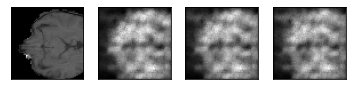

In [52]:
my_VAE=torch.load("./best_model")
for i,data in enumerate(train_pydl):
        img=data["MRI"]
        img=img[:,50:178:2,50:178:2,63]
        img=img-torch.mean(img,axis=(1,2),keepdims=True)
        img=img/torch.std(img,axis=(1,2),keepdims=True)
        img=img.unsqueeze(1).type(torch.FloatTensor)
        
        pre_img=img.numpy()
        recon = my_VAE.reconstruct(xs=img.cuda(), age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda())
        fig,axarr=plt.subplots(1,4)
        axarr[0].imshow(pre_img.squeeze(),cmap="gray")
        recon = my_VAE.reconstruct(xs=img.cuda(), age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda()-20)
        axarr[1].imshow(recon.detach().cpu().numpy().squeeze(),cmap="gray")
        recon = my_VAE.reconstruct(xs=img.cuda(), age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda())
        axarr[2].imshow(recon.detach().cpu().numpy().squeeze(),cmap="gray")
        recon = my_VAE.reconstruct(xs=img.cuda(), age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda()+20)
        axarr[3].imshow(recon.detach().cpu().numpy().squeeze(),cmap="gray")
        for ax in axarr:
            ax.set_xticks([])
            ax.set_yticks([])
        break
        

In [16]:
#plt.imshow(my_VAE.reconstruct(torch.Tensor(resha_slice),age=torch.Tensor([[50]]).view(1,1)).detach().numpy().squeeze())